In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import itertools
import seaborn as sns

import joblib

In [2]:
class config:
    
    NUM_FOLDS = 5
    
    TRAIN_PATH = "../input/nmims-m2-batch-5/train.csv"
    
    TEST_PATH = "../input/nmims-m2-batch-5/test.csv"

In [3]:
train = pd.read_csv(config.TRAIN_PATH)
test = pd.read_csv(config.TEST_PATH)

In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (1590, 10)
Test shape: (397, 9)


In [5]:
train.head()

,id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1144,33,Government Sector,Yes,800000,5,1,No,No,0
1,1213,28,Private Sector/Self Employed,Yes,1100000,4,1,Yes,No,0
2,1138,27,Government Sector,Yes,500000,4,0,No,No,0
3,1329,28,Private Sector/Self Employed,Yes,550000,4,0,Yes,No,0
4,1446,33,Private Sector/Self Employed,Yes,550000,7,1,Yes,No,1


<AxesSubplot:>

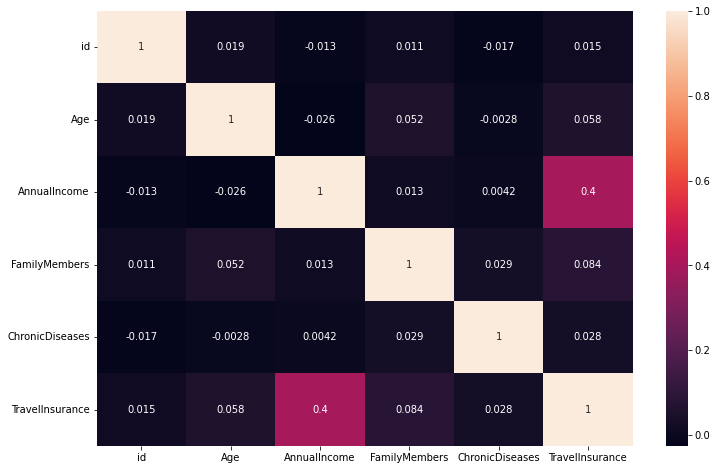

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True)

In [7]:
train.TravelInsurance.value_counts()

0    1014
1     576
Name: TravelInsurance, dtype: int64

In [8]:
train['Employment Type'].value_counts()

Private Sector/Self Employed    1130
Government Sector                460
Name: Employment Type, dtype: int64

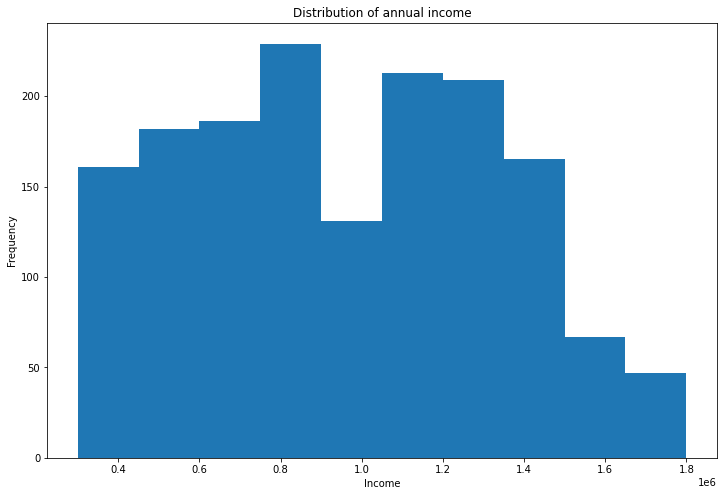

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(train.AnnualIncome)
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Distribution of annual income")
plt.show()

In [10]:
print(f"Variance in annual income before transformation: {train.AnnualIncome.var()}")

Variance in annual income before transformation: 139493198127.06006


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1590 non-null   int64 
 1   Age                  1590 non-null   int64 
 2   Employment Type      1590 non-null   object
 3   GraduateOrNot        1590 non-null   object
 4   AnnualIncome         1590 non-null   int64 
 5   FamilyMembers        1590 non-null   int64 
 6   ChronicDiseases      1590 non-null   int64 
 7   FrequentFlyer        1590 non-null   object
 8   EverTravelledAbroad  1590 non-null   object
 9   TravelInsurance      1590 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 124.3+ KB


In [12]:
def feature_engineering(df, cat_cols):
    combi = list(itertools.combinations(cat_cols, 2))
    print(f"Total combinations: {len(combi)}")
    for c1, c2 in combi:
        df.loc[:, c1 + "_" + c2] = df[c1].astype(str) + "_" + df[c2].astype(str)
    return df

# Cleaning

- LabelEncoder
- Using log transformation on AnnualIncome

In [13]:
test.loc[:, "TravelInsurance"] = -1

data = pd.concat([train, test]).reset_index(drop=True)

# use log transformation on annualincome
data['AnnualIncome'] = data['AnnualIncome'].apply(lambda x: np.log(1 + x))

# add features using feature engineering function
num_cols = ["Age", "AnnualIncome", "FamilyMembers"]
cat_cols = [c for c in data.columns if c not in num_cols and c not in ("id", "TravelInsurance")]
data = feature_engineering(data, cat_cols)

# data.head()

features_to_encode = [c for c in data.columns if c not in num_cols and c not in ("id", "TravelInsurance")]

for feature in features_to_encode:
    encoder = preprocessing.LabelEncoder()
    temp_col = data[feature].values
    data.loc[:, feature] = encoder.fit_transform(temp_col)
    
train = data[data.TravelInsurance != -1].reset_index(drop=True)
test = data[data.TravelInsurance == -1].reset_index(drop=True)
test = test.drop(['TravelInsurance'], axis=1)

Total combinations: 10


In [14]:
train.head()

,id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Employment Type_GraduateOrNot,Employment Type_ChronicDiseases,Employment Type_FrequentFlyer,Employment Type_EverTravelledAbroad,GraduateOrNot_ChronicDiseases,GraduateOrNot_FrequentFlyer,GraduateOrNot_EverTravelledAbroad,ChronicDiseases_FrequentFlyer,ChronicDiseases_EverTravelledAbroad,FrequentFlyer_EverTravelledAbroad
0,1144,33,0,1,13.592368,5,1,0,0,0,1,1,0,0,3,2,2,2,2,0
1,1213,28,1,1,13.910822,4,1,1,0,0,3,3,3,2,3,3,2,3,2,2
2,1138,27,0,1,13.122365,4,0,0,0,0,1,0,0,0,2,2,2,0,0,0
3,1329,28,1,1,13.217675,4,0,1,0,0,3,2,3,2,2,3,2,1,0,2
4,1446,33,1,1,13.217675,7,1,1,0,1,3,3,3,2,3,3,2,3,2,2


In [15]:
train.columns

Index(['id', 'Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome',
       'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer',
       'EverTravelledAbroad', 'TravelInsurance',
       'Employment Type_GraduateOrNot', 'Employment Type_ChronicDiseases',
       'Employment Type_FrequentFlyer', 'Employment Type_EverTravelledAbroad',
       'GraduateOrNot_ChronicDiseases', 'GraduateOrNot_FrequentFlyer',
       'GraduateOrNot_EverTravelledAbroad', 'ChronicDiseases_FrequentFlyer',
       'ChronicDiseases_EverTravelledAbroad',
       'FrequentFlyer_EverTravelledAbroad'],
      dtype='object')

In [16]:
train.TravelInsurance.value_counts()

0    1014
1     576
Name: TravelInsurance, dtype: int64

In [17]:
test.head()

,id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,Employment Type_GraduateOrNot,Employment Type_ChronicDiseases,Employment Type_FrequentFlyer,Employment Type_EverTravelledAbroad,GraduateOrNot_ChronicDiseases,GraduateOrNot_FrequentFlyer,GraduateOrNot_EverTravelledAbroad,ChronicDiseases_FrequentFlyer,ChronicDiseases_EverTravelledAbroad,FrequentFlyer_EverTravelledAbroad
0,0,27,0,1,13.122365,5,0,0,0,1,0,0,0,2,2,2,0,0,0
1,9,34,1,1,13.864302,4,0,0,0,3,2,2,2,2,2,2,0,0,0
2,14,29,1,1,13.997833,4,0,0,0,3,2,2,2,2,2,2,0,0,0
3,31,25,1,1,14.151984,7,0,0,1,3,2,2,3,2,2,3,0,1,1
4,41,31,1,1,14.151984,6,0,0,1,3,2,2,3,2,2,3,0,1,1


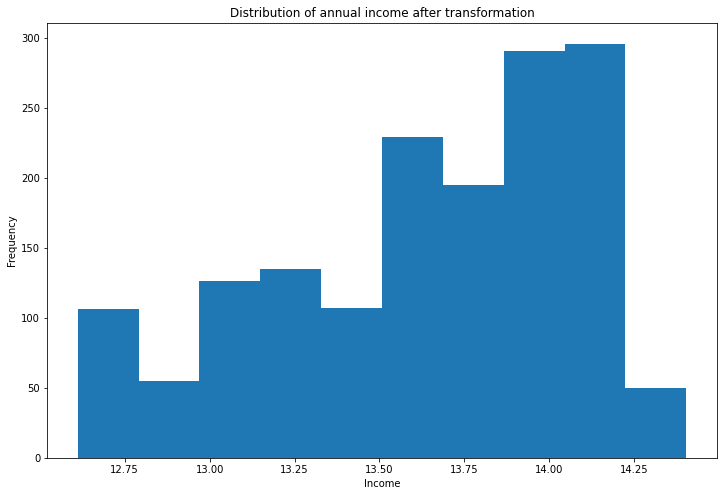

In [18]:
plt.figure(figsize=(12, 8))
plt.hist(train.AnnualIncome)
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Distribution of annual income after transformation")
plt.show()

In [19]:
print(f"Variance in annual income after log transformation: {train.AnnualIncome.var()}")

Variance in annual income after log transformation: 0.20743466019423776


# Create folds

In [20]:
def create_folds(df):
    
    df['kfold'] = -1
    
    df = df.sample(frac=1).reset_index(drop=True)
    
    y = df.TravelInsurance.values
    
    skf = model_selection.StratifiedKFold(config.NUM_FOLDS)
    
    for f, (t_, v_) in enumerate(skf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    
    return df

In [21]:
train_folds = create_folds(train)
train_folds.kfold.value_counts()

0    318
1    318
2    318
3    318
4    318
Name: kfold, dtype: int64

# Model dispatcher

In [22]:
from sklearn import linear_model
from sklearn import tree
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

model_dispatcher = {
    "lgbm_model": lgbm.LGBMClassifier(n_jobs=-1),
    "xgboost_model": xgb.XGBClassifier(n_jobs=-1),
    "catboost_model": cb.CatBoostClassifier(verbose=0)
}

# Modeling

In [23]:
def run(df, fold, model, model_name, save_model=None):
    
    train_df = df[df.kfold != fold].reset_index(drop=True)
    val_df = df[df.kfold == fold].reset_index(drop=True)
    
    xtrain = train_df.drop(['TravelInsurance', 'id', 'kfold'], axis=1)
    xval = val_df.drop(['TravelInsurance', 'id', 'kfold'], axis=1)
    
    model.fit(xtrain, train_df.TravelInsurance)
    
    valid_preds = model.predict_proba(xval)[:, 1]
    
    score =  metrics.roc_auc_score(val_df.TravelInsurance.values, valid_preds)
    
    if save_model is not None:
        if save_model in model_name:
            print(f"Saving {model_name} for fold {fold}")
            joblib.dump(model, f"{model_name}_{fold}.bin")
    
    return score

In [24]:
final_scores = {}
for model_name, model in model_dispatcher.items():
    print(f"Using {model_name}")
    scores = []
    for fold in range(5):
        score = run(train_folds, fold, model, model_name, save_model='xgboost')
        scores.append(score)
        
    final_scores[model_name] = scores

Using lgbm_model
Using xgboost_model
[09:26:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Saving xgboost_model for fold 0
[09:26:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Saving xgboost_model for fold 1
[09:26:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Saving xgboost_model for fold 2
[09:26:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Saving xgboost_model for fold 3
[09:26:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Saving xgboost_model for fold 4
Using catboost_model


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [25]:
final_df_scores = pd.DataFrame(final_scores)
final_df_scores = final_df_scores.T
final_df_scores.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
final_df_scores['CV'] = (final_df_scores["f0"] + final_df_scores["f1"] + final_df_scores["f2"] + final_df_scores["f3"] + final_df_scores["f4"]) / 5
final_df_scores

,f0,f1,f2,f3,f4,CV
lgbm_model,0.799270,0.802934,0.750525,0.788927,0.836603,0.795652
xgboost_model,0.809641,0.799165,0.731034,0.792868,0.826066,0.791755
catboost_model,0.801447,0.798394,0.762690,0.777318,0.815057,0.790981


In [26]:
# from sklearn import tree
# plt.figure(figsize=(12,8))
# tree.plot_tree(model_dispatcher['dt'],
#                feature_names=list(train_folds.drop(['TravelInsurance', 'id', 'kfold'], axis=1).columns),
#                class_names= ["0", "1"],
#                filled = True)
# plt.show()

# Creating submission

In [27]:
sample_sub = pd.DataFrame()
sample_sub['id'] = test['id']

for i in range(5):
    model = joblib.load(f"xgboost_model_{i}.bin")
    try:
        test_preds += model.predict_proba(test.drop(["id"], axis=1))[:, 1]
    except:
        test_preds = model.predict_proba(test.drop(["id"], axis=1))[:, 1]
# take average of 5 folds' predictions
test_preds /= 5
sample_sub['TravelInsurance'] = test_preds

In [28]:
sample_sub.head()

,id,TravelInsurance
0,0,0.061233
1,9,0.458299
2,14,0.127281
3,31,0.995640
4,41,0.973035


In [29]:
print("Predictions value counts:")
((sample_sub.TravelInsurance > 0.5) * 1).value_counts()

Predictions value counts:


0    282
1    115
Name: TravelInsurance, dtype: int64

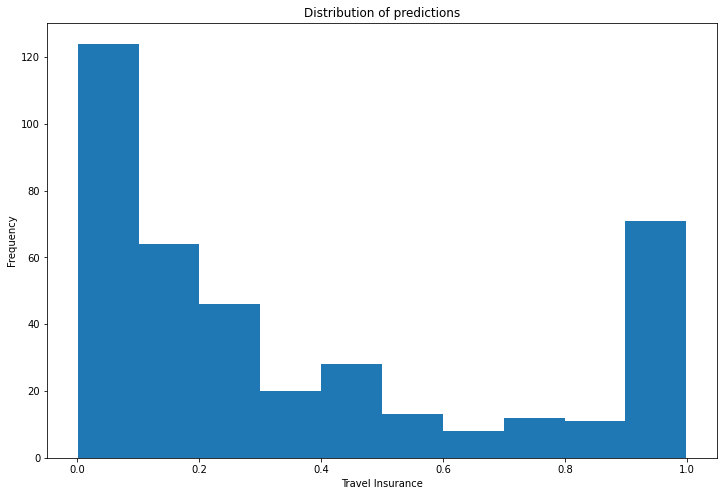

In [30]:
plt.figure(figsize=(12, 8))
plt.hist(sample_sub.TravelInsurance)
plt.xlabel("Travel Insurance")
plt.ylabel("Frequency")
plt.title("Distribution of predictions")
plt.show()

In [31]:
sample_sub.to_csv("xgb_log_income_feat_eng.csv", index=False)